In [305]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import scipy
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sys
sys.path.insert(0, "../Scripts")

%run ../Scripts/trajectory.py
%run ../Scripts/trajectoryVisual.py
%run ../Scripts/trajsTree.py
%run ../Scripts/supMethods.py
%run ../Scripts/analysisMethods.py

foldername = '../Data_temp_name10/beta-0.02_seed1'

In [111]:
params, sim_params = read_json(foldername)

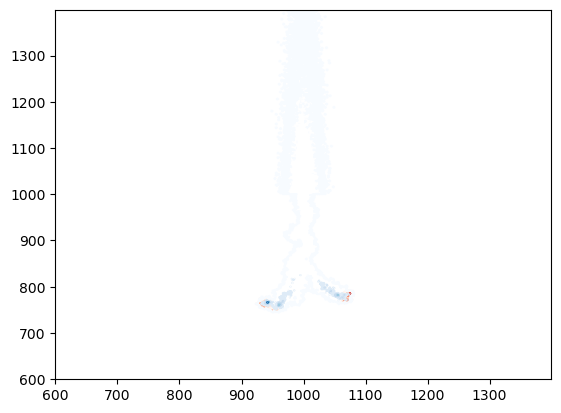

In [147]:
tdom= get_tdomain(foldername, to_plot = True, margins=(-0.3, -0.3))

In [159]:
n, nh, f = load_outputs(foldername, tdom[0], add_fitness=True)

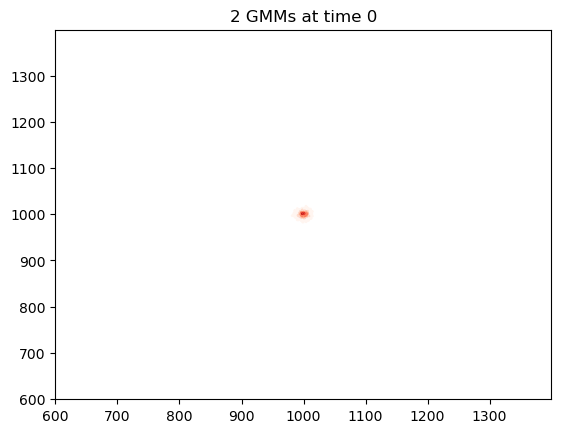

In [160]:
means, covs, counts = fit_GMM(n, params, sim_params, n_components=2)
plot_Ellipses(n, 0, means, covs, input_color = 'b', margins = (-0.3, -0.3))

In [249]:
n_component = 1

num_obs = len(n.nonzero()[0])
chi_array = []
component_range = range(1, 9)
for n_component in component_range:
    n_normalized = n.toarray()/np.sum(n)
    means, covs, counts, chi_sq_red = fit_GMM(n, params, sim_params, 
                                              n_components = n_component, return_chi_sq=True)
    chi_array.append(chi_sq_red)

/Users/zhizhang144515/Documents/CRISPR_Sim/Scripts/trajectory.py:183: RuntimeWarning: divide by zero encountered in scalar divide
  diff = np.power(val - pred, 2)/np.linalg.det(cov)


In [308]:
means, covs, counts = fit_GMM_unknown_components(n, params, sim_params, index_nonzero_w_repeats = [], 
                               num_components_max = 10, scale = 1, plot_chi_sq = False)

/Users/zhizhang144515/Documents/CRISPR_Sim/Scripts/trajectory.py:187: RuntimeWarning: divide by zero encountered in scalar divide
  chi_sq_red = chi_sq/n_deg_freedom


In [ ]:
from entropy import compute_entropy
from trajectory import fit_GMM, get_nonzero_no_repeats
ent = compute_entropy(n)
print("Truth ", -1*ent)
entropy_list = []
n_gaussian = []

for i in range(40):
    means, covs, counts = fit_GMM(n, params, sim_params, n_components=i+1)
    model_S = 0
    i = 0
    for cov, count in zip(covs, counts):
        i+=1
        model_S += count*(np.log(np.linalg.det(cov))/2 +(1+np.log(2*np.pi)))
    # print(i, " ", model_S, " ", counts)
    entropy_list.append(model_S)
    n_gaussian.append(i+1)

Text(0, 0.5, 'Number of Gaussians')

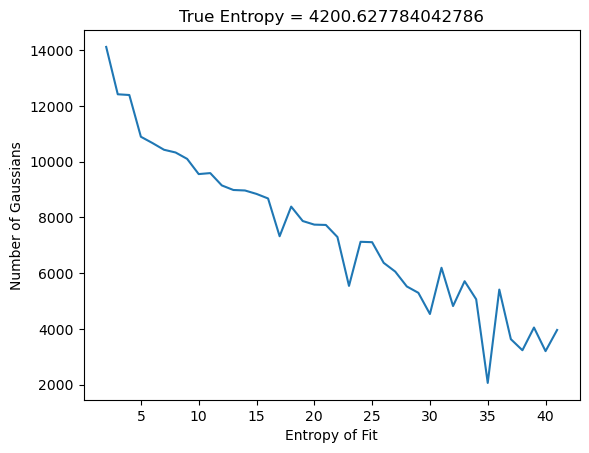

In [110]:
plt.figure()
plt.title(f"True Entropy = {-1*ent}")
plt.plot(n_gaussian, entropy_list)
plt.xlabel("Entropy of Fit")
plt.ylabel("Number of Gaussians")